In [1]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
#from keras.preprocessing.image import load_img   //not working in Colab
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array   //not working in Colab
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [2]:
image_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset/Flicker8k_Dataset'
caption_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset/Flickr8k_text/Flickr8k.token.txt'

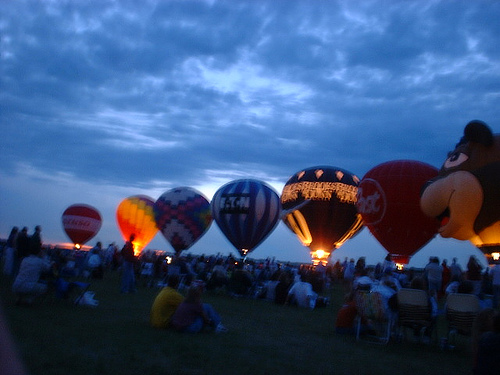

In [3]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset/Flicker8k_Dataset/107318069_e9f2ef32de.jpg')

In [4]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

In [5]:
captions_dict

{'1000268201_693b08cb0e': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1001773457_577c3a7d70': 'A black dog and a spotted dog are fighting',
 '1002674143_1b742ab4b8': 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 '1003163366_44323f5815': 'A man lays on a bench while his dog sits by him .',
 '1007129816_e794419615': 'A man in an orange hat starring at something .',
 '1007320043_627395c3d8': 'A child playing on a rope net .',
 '1009434119_febe49276a': 'A black and white dog is running in a grassy garden surrounded by a white fence .',
 '1012212859_01547e3f17': 'A dog shakes its head near the shore , a red ball next to it .',
 '1015118661_980735411b': 'A boy smiles in front of a stony wall in a city .',
 '1015584366_dfcec3c85a': 'A black dog leaps over a log .',
 '101654506_8eb26cfb60': 'A brown and white dog is running through the snow .',
 '101669240_b2d3e7f17b': 'A man in a hat is displaying pictures ne

In [6]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [7]:
new_captions_dict

{'1000268201_693b08cb0e': 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 '1001773457_577c3a7d70': 'startseq black dog and spotted dog are fighting endseq',
 '1002674143_1b742ab4b8': 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 '1003163366_44323f5815': 'startseq man lays on bench while his dog sits by him endseq',
 '1007129816_e794419615': 'startseq man in an orange hat starring at something endseq',
 '1007320043_627395c3d8': 'startseq child playing on rope net endseq',
 '1009434119_febe49276a': 'startseq black and white dog is running in grassy garden surrounded by white fence endseq',
 '1012212859_01547e3f17': 'startseq dog shakes its head near the shore red ball next to it endseq',
 '1015118661_980735411b': 'startseq boy smiles in front of stony wall in city endseq',
 '1015584366_dfcec3c85a': 'startseq black dog leaps over log endseq',
 '101654506_8eb26cfb60': 'startseq brown and white d

In [8]:
# delete unwanted 
del captions_dict

In [9]:
len(new_captions_dict)

8092

In [10]:
from pickle import *
import pickle
dump(new_captions_dict, open('/content/drive/MyDrive/Colab Notebooks/new_caption_dict.pkl', 'wb'))

In [11]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]
caption_images_list[0]

'3758787457_1a903ee1e9'

In [12]:
len(caption_images_list)

8091

In [15]:
train_validate_images = caption_images_list[0:8081] 
dump(train_validate_images, open('/content/drive/MyDrive/Colab Notebooks/train_validate_images.pkl', 'wb'))

In [14]:
test_images = caption_images_list[8081:8091]
test_images

['109823394_83fcb735e1',
 '110595925_f3395c8bd6',
 '1095590286_c654f7e5a9',
 '109823395_6fb423a90f',
 '1096097967_ac305887b4',
 '1095476286_87d4f8664e',
 '111537217_082a4ba060',
 '1096165011_cc5eb16aa6',
 '1110208841_5bb6806afe',
 '1104133405_c04a00707f']

In [ ]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    count=1
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
        print('>%s' % name,count)
        count+=1
        

    return features

In [ ]:
i=load_img(image_dataset_path+"/109823394_83fcb735e1.jpg",target_size=(224,224))

In [ ]:
train_validate_features = extract_features(image_dataset_path, train_validate_images)

Streaming output truncated to the last 5000 lines.
>3134586018_ae03ba20a0 3082
>3138504165_c7ae396294 3083
>3139118874_599b30b116 3084
>3138562460_44227a35cf 3085
>3136404885_f4d8f1d15a 3086
>3139393607_f0a54ca46d 3087
>3135504530_0f4130d8f8 3088
>3134341610_3c55e373a7 3089
>3139238055_2817a0c7d8 3090
>3143991972_7193381aeb 3091
>3143953179_1c08c023a5 3092
>3139160252_75109e9e05 3093
>3139895886_5a6d495b13 3094
>3139876823_859c7d7c23 3095
>3141440149_00becbbb93 3096
>3143978284_ac086be9a3 3097
>3138746531_f6b816c126 3098
>3136688093_568b053bdf 3099
>3143159297_6f2f663ea6 3100
>3134387321_3a253224c1 3101
>3141613533_595723208d 3102
>3143982558_9e2d44c155 3103
>3134585858_a8c3493ca5 3104
>3137061312_eb5fdcf3fd 3105
>3143765063_a7761b16d3 3106
>3138433655_ea1d59e5b7 3107
>3141293960_74459f0a24 3108
>3145869775_85dfae43bd 3109
>3136674757_57406c305c 3110
>3134387513_ceb75bea0a 3111
>3134385454_4f1d55333f 3112
>3143155555_32b6d24f34 3113
>3143980056_7a64a94b58 3114
>3139837262_fe5ee7ccd9 31

In [ ]:
print("{} : {}".format(list(train_validate_features.keys())[0],
                       train_validate_features[list(train_validate_features.keys())[0]] ))

3758787457_1a903ee1e9 : [[0.7913177  3.9417074  0.01223755 ... 0.         2.46762    2.0536573 ]]


In [ ]:
len(train_validate_features)

8081

In [ ]:
from pickle import *
import pickle
dump(train_validate_features, open('/content/drive/MyDrive/Colab Notebooks/train_validate_features.pkl', 'wb'))

In [ ]:
import pickle
obj=open('/content/drive/MyDrive/Colab Notebooks/train_validate_features.pkl', 'rb')
train_validate_features=pickle.load(obj)

In [ ]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical, plot_model
# from keras.layers.merge import add
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [ ]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

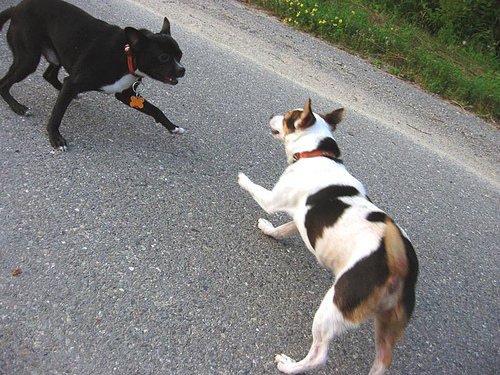

In [ ]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [ ]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [ ]:
len(train_x1)

72236

In [ ]:
len(validate_x1)

10319

In [ ]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = concatenate([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1148416     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

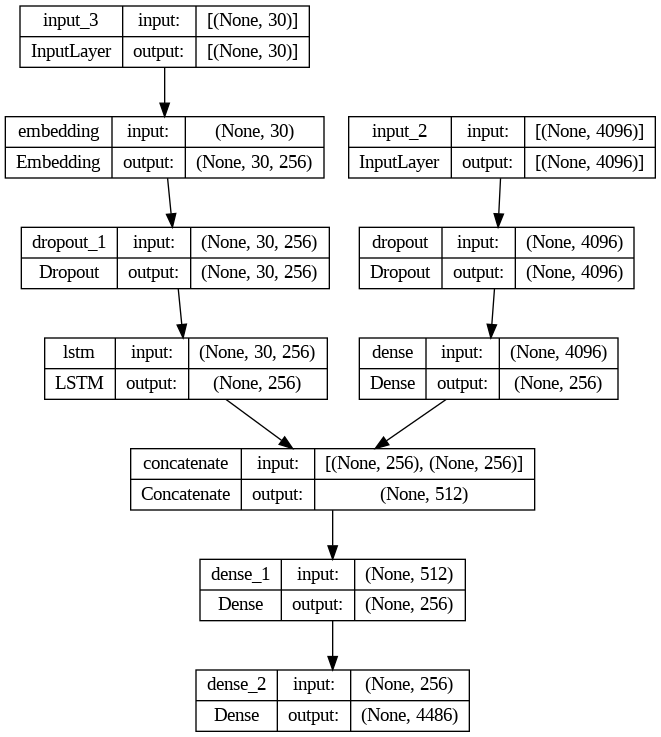

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [ ]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72236, 4096)
shape of train_x2  (72236, 30)
shape of train_y  (72236, 4486)

shape of validate_x1  (10319, 4096)
shape of validate_x2  (10319, 30)
shape of validate_y  (10319, 4486)


In [ ]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y)) 

Epoch 1/20
2258/2258 [==============================] - 205s 91ms/step - loss: 2.8009 - val_loss: 5.2083
Epoch 2/20
2258/2258 [==============================] - 202s 90ms/step - loss: 2.7299 - val_loss: 5.3493
Epoch 3/20
2258/2258 [==============================] - 203s 90ms/step - loss: 2.6601 - val_loss: 5.4546
Epoch 4/20
2258/2258 [==============================] - 201s 89ms/step - loss: 2.6062 - val_loss: 5.6417
Epoch 5/20
2258/2258 [==============================] - 202s 90ms/step - loss: 2.5530 - val_loss: 5.7145
Epoch 6/20
2258/2258 [==============================] - 202s 89ms/step - loss: 2.5095 - val_loss: 5.7631
Epoch 7/20
2258/2258 [==============================] - 204s 90ms/step - loss: 2.4651 - val_loss: 5.9038
Epoch 8/20
2258/2258 [==============================] - 203s 90ms/step - loss: 2.4116 - val_loss: 6.0626
Epoch 9/20
2258/2258 [==============================] - 203s 90ms/step - loss: 2.3809 - val_loss: 6.1633
Epoch 10/20
2258/2258 [==============================] 

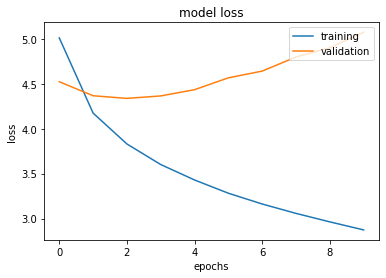

In [ ]:
# plot training loss and validation loss for 10 epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

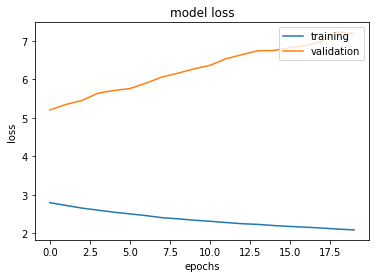

In [ ]:
# plot training loss and validation loss for 20 epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
# saving the model with last parameters 
model.save('/content/drive/MyDrive/Colab Notebooks/latest20epochs.h5')

In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None
 

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

553467096/553467096 [==============================] - 24s 0us/step


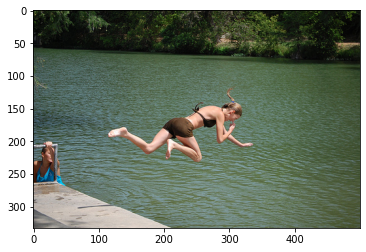

Predicted caption ->  startseq boy in blue shirt is jumping into the water endseq

Actual caption ->  startseq girl dives into the water while another girl watches her endseq
*********************************************************************



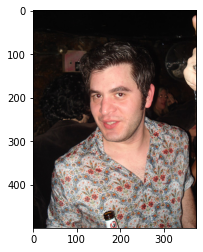

Predicted caption ->  startseq man and woman are sitting on the street with his mouth endseq

Actual caption ->  startseq man in patterned shirt holds beer bottle endseq
*********************************************************************



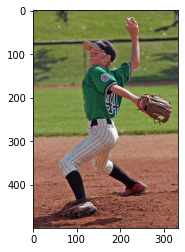

Predicted caption ->  startseq boy in red uniform in red shirt is playing baseball endseq

Actual caption ->  startseq boy pitches in baseball game endseq
*********************************************************************



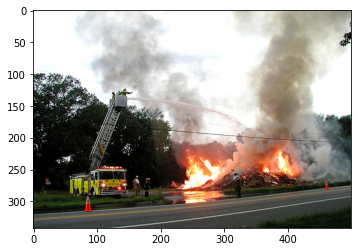

Predicted caption ->  startseq group of people are standing in the street endseq

Actual caption ->  startseq firetruck fights fire endseq
*********************************************************************



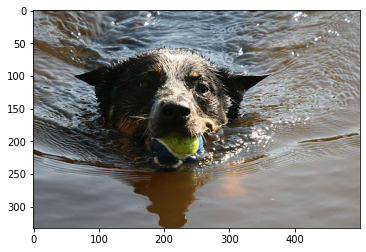

Predicted caption ->  startseq black dog is running through the water toward the water endseq

Actual caption ->  startseq black dog is swimming while carrying tennis endseq
*********************************************************************



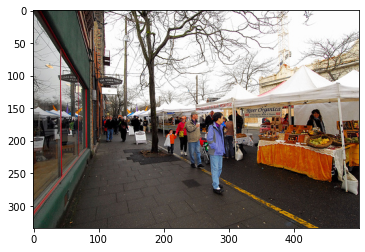

Predicted caption ->  startseq group of people are standing in front of mosque endseq

Actual caption ->  startseq crowd walks along sidewalk of farmers market endseq
*********************************************************************



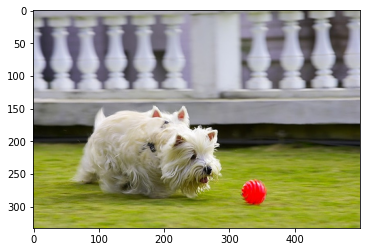

Predicted caption ->  startseq black and white dog is jumping over red and white dog endseq

Actual caption ->  startseq two small white dogs are in yard chasing red ball endseq
*********************************************************************



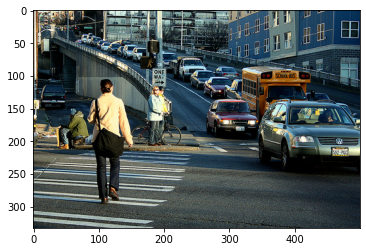

Predicted caption ->  startseq man in black jacket is standing in front of large night endseq

Actual caption ->  startseq busy highway scene with woman crossing crosswalk on the left endseq
*********************************************************************



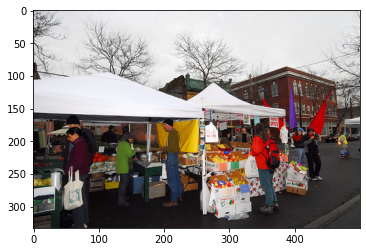

Predicted caption ->  startseq group of people are standing in front of crowd endseq

Actual caption ->  startseq group of people stand at farmers market on dreary day endseq
*********************************************************************



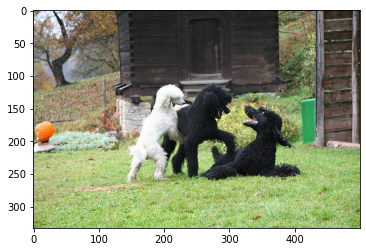

Predicted caption ->  startseq black and white dog is running on the grass endseq

Actual caption ->  startseq white dog and two black dogs playing endseq
*********************************************************************



In [ ]:
from PIL import Image
from keras.models import load_model
# load the model
modl = load_model('/content/drive/MyDrive/Colab Notebooks/latest10epochs.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  
    im=Image.open('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))
    plt.imshow(im)
    plt.show()
    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

In [ ]:
from PIL import Image
from keras.models import load_model
# load the model
modl = load_model('/content/drive/MyDrive/Colab Notebooks/latest20epochs.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(50):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  
    im=Image.open('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))
    plt.imshow(im)
    plt.show()
    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from PIL import Image
from keras.models import load_model
# load the model
modl = load_model('/content/drive/MyDrive/Colab Notebooks/latest20epochs.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(50,75):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  
    im=Image.open('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))
    plt.imshow(im)
    plt.show()
    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Output hidden; open in https://colab.research.google.com to view.